# Team01 Jupyter Notebook: Predictive Analysis of Bike Idle Times Using Ensemble Learning in a Bike Sharing System
## Table of Contents
### 1. Data Cleanup
### 2. Calculate Idle Time and other features + merge Bike- and Weatherset
### 3. Descriptive Analytics
### 4. Predictive Analytics

### 1. Data Cleanup
#### Import Modules
Import all the necessary libraries for data loading, cleaning, analysis, visualization, and model building

In [1]:
import folium
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from geopy import distance
from datetime import datetime
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import StackingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#### Weatherset
Load and clean the weather data. The weather data is loaded from a CSV file.
Missing values are filled by calculating the mean values of all columns for each day.

In [2]:
weather_set_dirty = pd.read_csv('CSV/Weather_LosAngeles.csv', sep=",")
weather_set_dirty['timestamp'] = pd.to_datetime(weather_set_dirty['timestamp'])

mean_values_by_day = weather_set_dirty.groupby(weather_set_dirty["timestamp"].dt.date).mean(numeric_only=True).round(1)

for col in mean_values_by_day.columns:
    weather_set_dirty[col] = weather_set_dirty.apply(
        lambda row: mean_values_by_day.loc[row['timestamp'].date(), col]
        if pd.isnull(row[col]) else row[col],
        axis=1
    )

weather_set_dirty['cloud_cover_description'].fillna(method='ffill',inplace=True)

#### Bikeset
Load and clean the bike sharing data.
The data is sorted by station ID, missing latitude and longitude values for start and end stations are filled, and the start and end time columns are transformed into datetime objects.

In [3]:
bike_set_dirty = pd.read_csv('CSV/metro_2017_2022.csv', sep=',', index_col=0)

bike_set_dirty.sort_values('start_station_id')
bike_set_dirty['start_station_lat'].fillna(method="ffill", inplace=True)
bike_set_dirty['start_station_lon'].fillna(method="ffill", inplace=True)

bike_set_dirty.sort_values('end_station_id')
bike_set_dirty['end_station_lat'].fillna(method="ffill", inplace=True)
bike_set_dirty['end_station_lon'].fillna(method="ffill", inplace=True)

bike_set_dirty_agg_start = bike_set_dirty.groupby('start_station_id')[['start_station_lat', 'start_station_lon']].agg(lambda x: x.mode().iloc[0])
bike_set_dirty_agg_end = bike_set_dirty.groupby('end_station_id')[['end_station_lat', 'end_station_lon']].agg(lambda x: x.mode().iloc[0])

bike_set_dirty_merge = bike_set_dirty.merge(bike_set_dirty_agg_start, on='start_station_id', suffixes=('','_mode'))
bike_set_dirty_merged = bike_set_dirty_merge.merge(bike_set_dirty_agg_end, on='end_station_id', suffixes=('','_mode'))

dateformat0 = "%H/%M/%S %d-%m-%Y"
dateformat1 = "%Y-%m-%d %H:%M:%S"
for i, row in bike_set_dirty_merged.iterrows():
    bike_set_dirty_merged.at[i, 'start_station_lat'] = bike_set_dirty_merged.loc[i, 'start_station_lat_mode']
    bike_set_dirty_merged.at[i, 'start_station_lon'] = bike_set_dirty_merged.loc[i, 'start_station_lon_mode']
    bike_set_dirty_merged.at[i, 'end_station_lat'] = bike_set_dirty_merged.loc[i, 'end_station_lat_mode']
    bike_set_dirty_merged.at[i, 'end_station_lon'] = bike_set_dirty_merged.loc[i, 'end_station_lon_mode']

    try:
        bike_set_dirty_merged.at[i, 'start_time'] = datetime.strptime(bike_set_dirty_merged.loc[i, 'start_time'], dateformat0)
    except ValueError:
        bike_set_dirty_merged.at[i, 'start_time'] = datetime.strptime(bike_set_dirty_merged.loc[i, 'start_time'], dateformat1)
    try:
        bike_set_dirty_merged.at[i, 'end_time'] = datetime.strptime(bike_set_dirty_merged.loc[i, 'end_time'], dateformat0)
    except ValueError:
        bike_set_dirty_merged.at[i, 'end_time'] = datetime.strptime(bike_set_dirty_merged.loc[i, 'end_time'], dateformat1)

bike_set_almost_clean = bike_set_dirty_merged
bike_set_clean = bike_set_almost_clean.drop(['start_station_lat_mode', 'start_station_lon_mode', 'end_station_lat_mode', 'end_station_lon_mode'], axis=1)
bike_set_clean['start_time'] = pd.to_datetime(bike_set_almost_clean['start_time'], format="%Y-%m-%d %H:%M:%S")
bike_set_clean['end_time'] = pd.to_datetime(bike_set_almost_clean['end_time'], format="%Y-%m-%d %H:%M:%S")

### 2. Calculate Idle Time and other features + merge Bike- and Weatherset
#### Idle Time
Calculate the idle time for each bike. The data is sorted by end time.
The idle time for each transaction is computed by calculating the time period from when bike with bike id = x was dropped off at station y until any other bike at station y is booked

In [4]:
metro = bike_set_clean
metro['idle_time'] = None
metro = metro.sort_values(by='end_time')

BigDict = {
    # station_id: {
    #     transaction_id: end_time
    # }
}

for i, row in metro.iterrows():
    current_start_time = row["start_time"]
    current_end_time = row["end_time"]
    current_end_station_id = row["end_station_id"]
    current_start_station_id = row["start_station_id"]
    current_bike_id = row["bike_id"]
    current_transaction_id = i

    if current_start_station_id in BigDict:
        for transaction in list(BigDict[current_start_station_id]):  # Create a copy of the keys
            if current_start_time < BigDict[current_start_station_id][transaction]:
                continue
            if metro.at[transaction, "idle_time"] is not None:
                continue
            idle_time = current_start_time - BigDict[current_start_station_id][transaction]
            metro.at[transaction, "idle_time"] = idle_time
            #if idle_time.total_seconds() >= 0:
            del BigDict[current_start_station_id][transaction]

    if current_end_station_id not in BigDict:
        BigDict[current_end_station_id] = {current_transaction_id: current_end_time}

    BigDict[current_end_station_id][current_transaction_id] = current_end_time

#### Additional Features
Add time-of-day and day-of-week features to the bike sharing data.
New columns for different times of the day (morning, forenoon, noon, afternoon, evening, and night) and days of the week (Monday to Sunday) are created and filled based on the start time of each bike trip.

In [5]:
metro = metro.sort_values(by='start_time')
#Create the corresponding columns
metro["morgens"] = 0
metro["vormittags"] = 0
metro["mittags"] = 0
metro["nachmittags"]=0
metro["abends"]=0
metro["nachts"]=0

#set the start and end of each day time
morgens = range(5,9)
vormittags = range(9,12)
mittags = range(12,15)
nachmittags = range(15,19)
abends = range(19, 23)
nachts = [23,0,1,2,3,4]

#This list will serve as string provider that we can insert later, to access the proper column
TagesZeiten = ["morgens", "vormittags", "mittags", "nachmittags", "abends", "nachts"]
#This list will serve to provide the start time of each day time, so we know when to change columns
Intervall_starts = [5,9,12,15,19,23]

metro["monday"] = 0
metro["tuesday"] = 0
metro["wednesday"] = 0
metro["thursday"] = 0
metro["friday"] = 0
metro["saturday"] = 0
metro["sunday"] = 0

Days = ["monday","tuesday","wednesday", "thursday","friday","saturday", "sunday"]

#Make sure to change the "idle_time" to a timedelta object, so we can use .totalseconds() later
metro["idle_time"] = pd.to_timedelta(metro["idle_time"])

# Iterate through each row in the DataFrame
for i, row in metro.iterrows():
    end_date = row["end_time"] + row["idle_time"]
    #we only need the starting time hour
    end_hour = end_date.hour
    # and we need to know the duration (idle time) we need to look back
    idle_time = row["idle_time"]
    # make sure to skip any rows with no idle times, since they have 0s in the day times columns
    try:
        NumHours = float(idle_time.total_seconds() / 3600)
        if end_hour in morgens:
            index = 0
        elif end_hour in vormittags:
            index = 1
        elif end_hour in mittags:
            index = 2
        elif end_hour in nachmittags:
            index = 3
        elif end_hour in abends:
            index = 4
        elif end_hour in nachts:
            index = 5

        while NumHours >0 and index > -6:
            metro.at[i, TagesZeiten[index]] = 1
            DistanceToIntervallStart = abs(Intervall_starts[index]- end_hour)

            NumHours -= DistanceToIntervallStart
            end_hour -= DistanceToIntervallStart
            index -= 1

        NumDays = float(row["idle_time"].total_seconds() / (24 * 60 * 60))

        day = end_date.weekday()

        while NumDays > 0 and day > -7:
            metro.at[i, Days[day]] = 1

            NumDays -= 1
            day -= 1

    except ValueError:
        continue


In [6]:
weather_set = weather_set_dirty
metro_set = metro

#### Merge Bike and Weatherset
Merge the metro and weather datasets based on the nearest timestamp.

In [7]:
metro_set.sort_values('start_time', inplace=True)
weather_set.sort_values('timestamp', inplace=True)

Weather_Set1 = weather_set.set_index('timestamp').reindex(metro_set.set_index('start_time').index, method='nearest')
Weather_Set1 = Weather_Set1.loc[~Weather_Set1.index.duplicated(keep='first')].reset_index()

merged_set = pd.merge(metro_set, Weather_Set1, on='start_time', how='left')
merged_set = merged_set.drop(['city'], axis=1)

Perform group by operations to get various metrics such as mean idle time, counts for different times of the day and days of the week, latitudes and longitudes of stations, etc. for each end station.

In [8]:
merged_set_descriptive = merged_set
mean_idle_time = merged_set_descriptive.groupby("end_station_id")["idle_time"].mean()

count_morning = merged_set_descriptive.groupby("end_station_id")["morgens"].sum()
count_vormittag = merged_set_descriptive.groupby("end_station_id")["vormittags"].sum()
count_midday = merged_set_descriptive.groupby("end_station_id")["mittags"].sum()
count_afternoon = merged_set_descriptive.groupby("end_station_id")["nachmittags"].sum()
count_evening = merged_set_descriptive.groupby("end_station_id")["abends"].sum()
count_night = merged_set_descriptive.groupby("end_station_id")["nachts"].sum()
count_mondays = merged_set_descriptive.groupby("end_station_id")["monday"].sum()
count_tuesdays = merged_set_descriptive.groupby("end_station_id")["tuesday"].sum()
count_wednesdays = merged_set_descriptive.groupby("end_station_id")["wednesday"].sum()
count_thursdays = merged_set_descriptive.groupby("end_station_id")["thursday"].sum()
count_fridays = merged_set_descriptive.groupby("end_station_id")["friday"].sum()
count_saturdays = merged_set_descriptive.groupby("end_station_id")["saturday"].sum()
count_sundays = merged_set_descriptive.groupby("end_station_id")["sunday"].sum()
station_lat = merged_set_descriptive.groupby("end_station_id")["end_station_lat"].unique()
station_lon = merged_set_descriptive.groupby("end_station_id")["end_station_lon"].unique()

result = pd.concat([mean_idle_time, count_morning, count_vormittag, count_midday, count_afternoon, count_evening, count_night, count_mondays, count_tuesdays, count_wednesdays, count_thursdays, count_fridays, count_saturdays, count_sundays, station_lat, station_lon], axis=1)
station_ID_with_AvgIdleDaytimesDays_and_lonlat = result.dropna(subset=["idle_time"])

### 3. Descriptive Analytics
#### Overall System Performance
Create new features for the dataset such as trip duration, hour, weekday, day, month, year, temperature_bin, and precipitation_category.
Additionally, calculate usage statistics by different timeframes, start and end stations, temperature, precipitation, and cloud cover.
Visualize these usage statistics using bar plots.


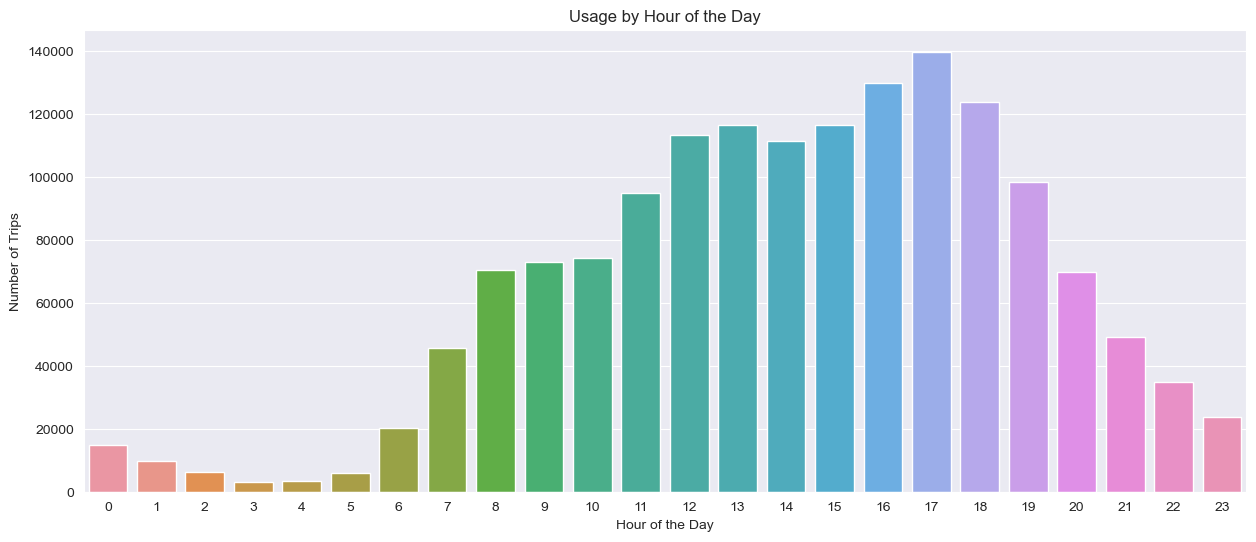

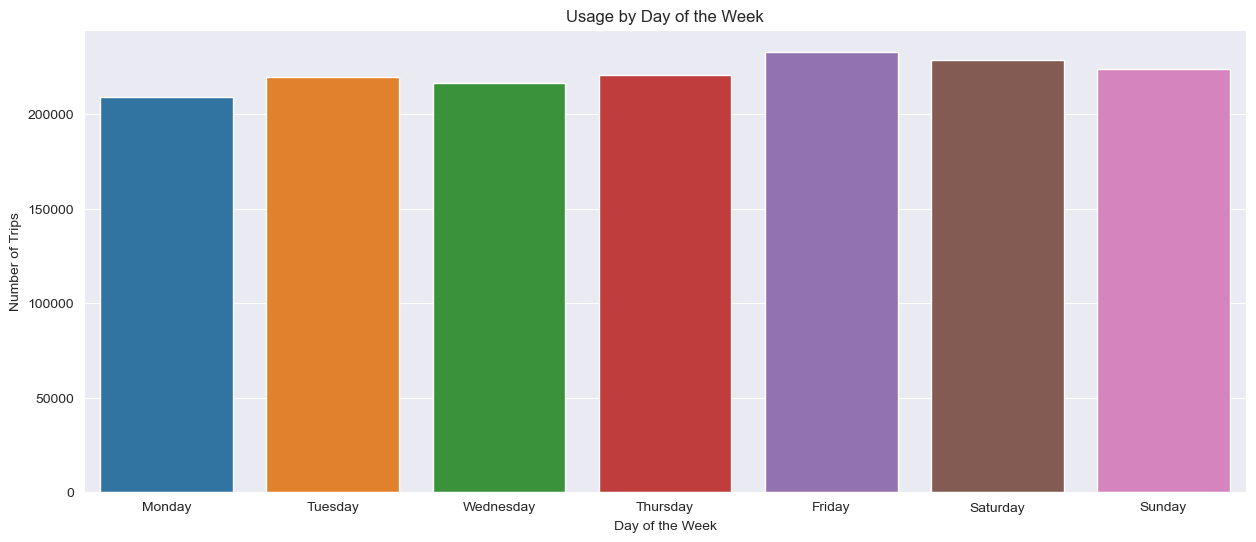

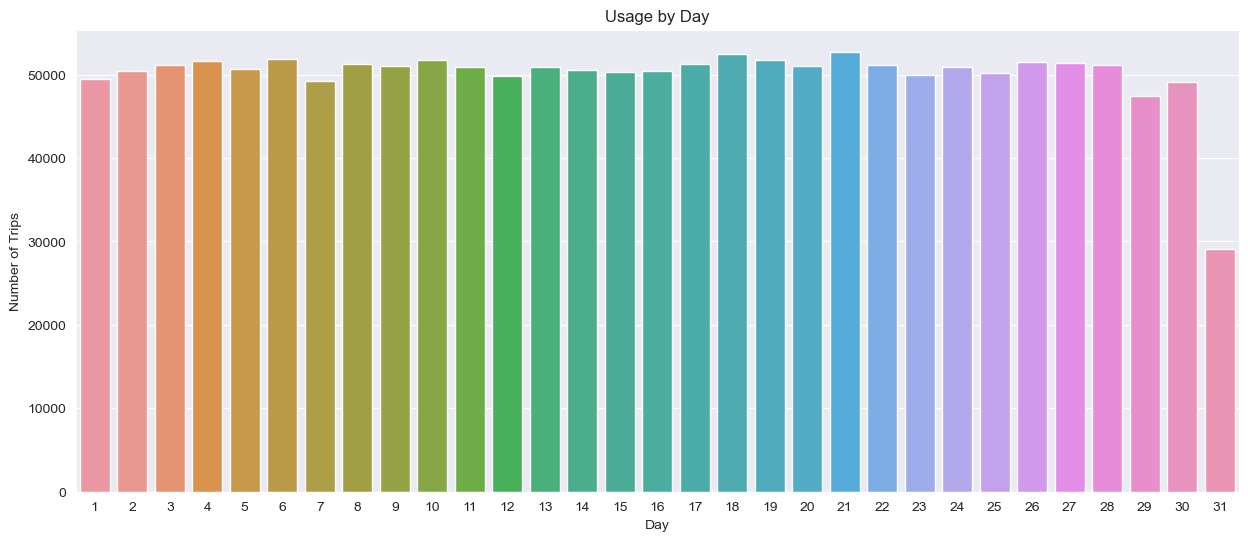

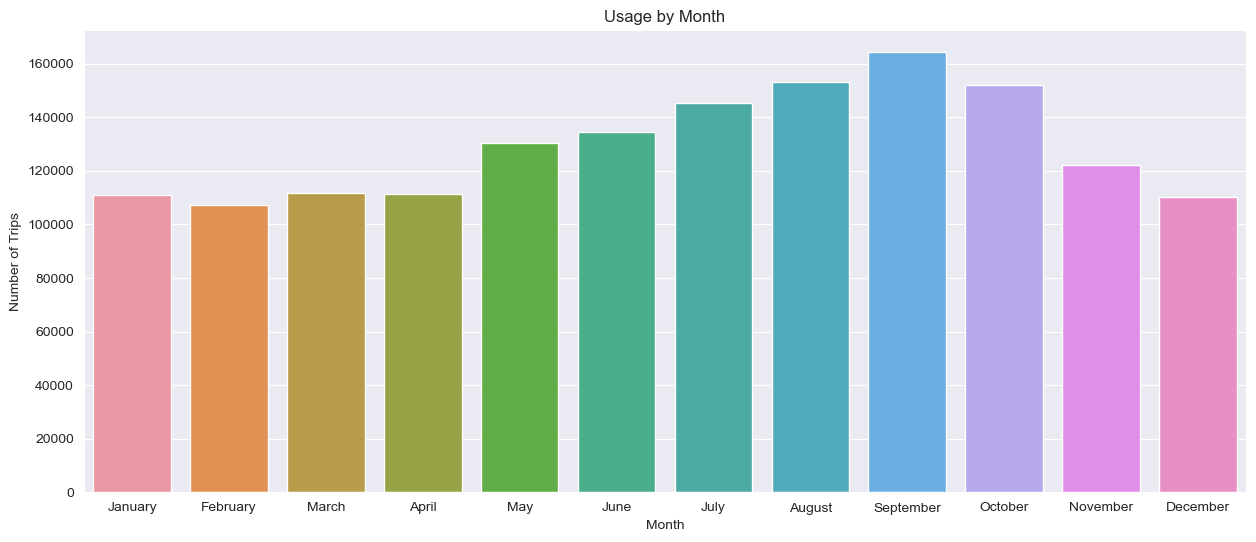

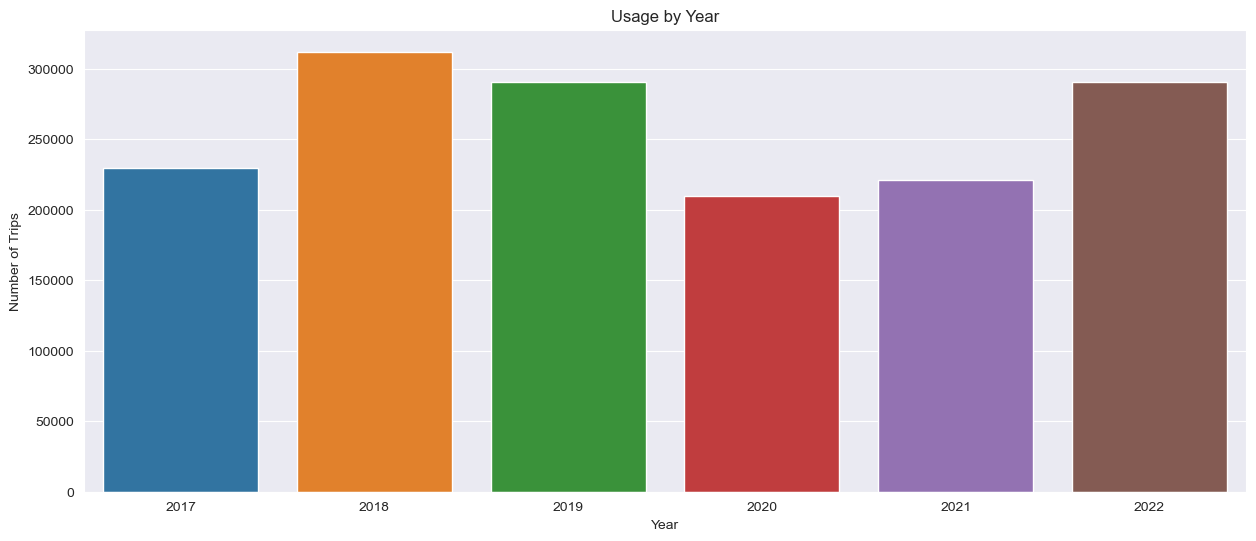

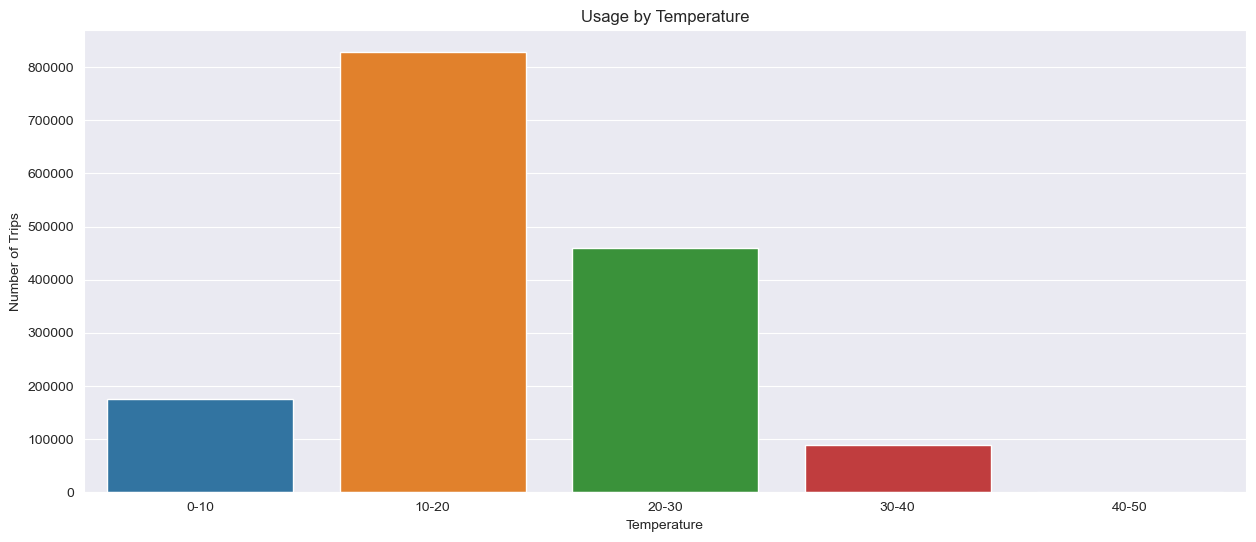

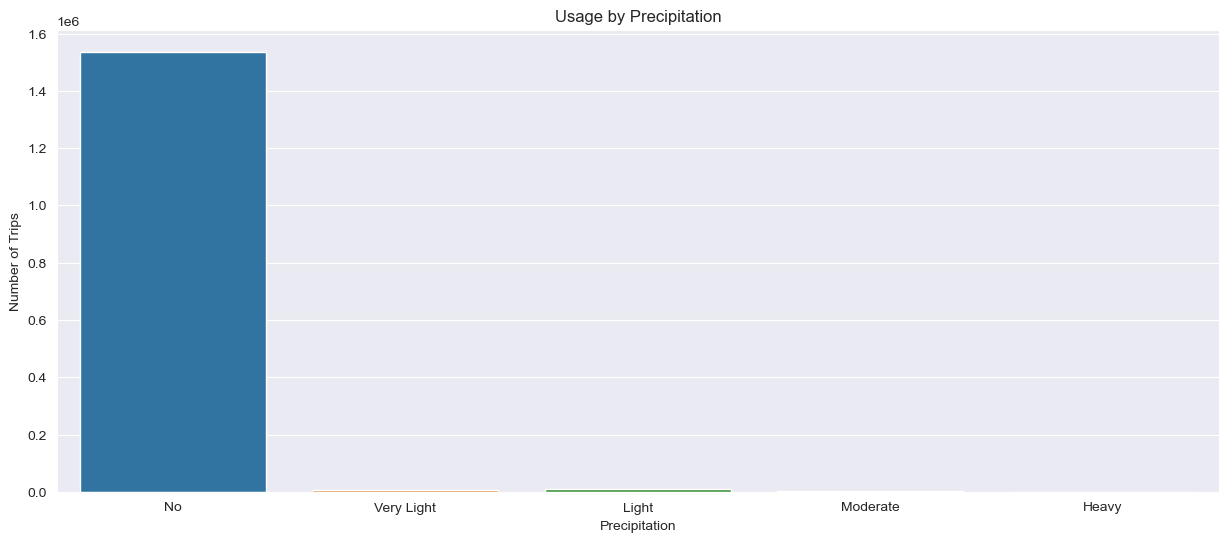

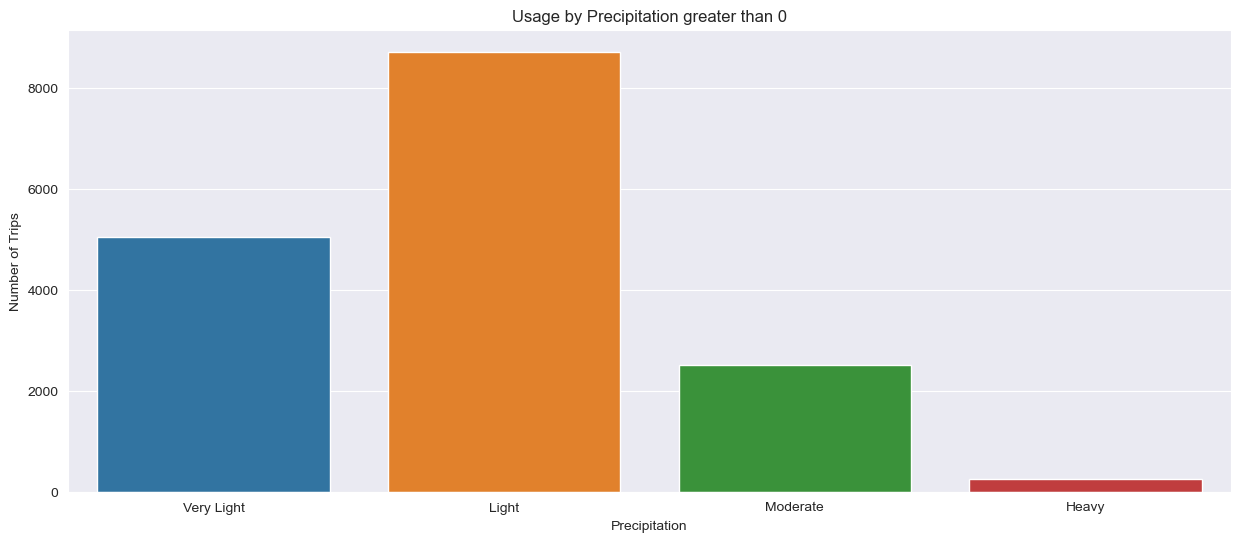

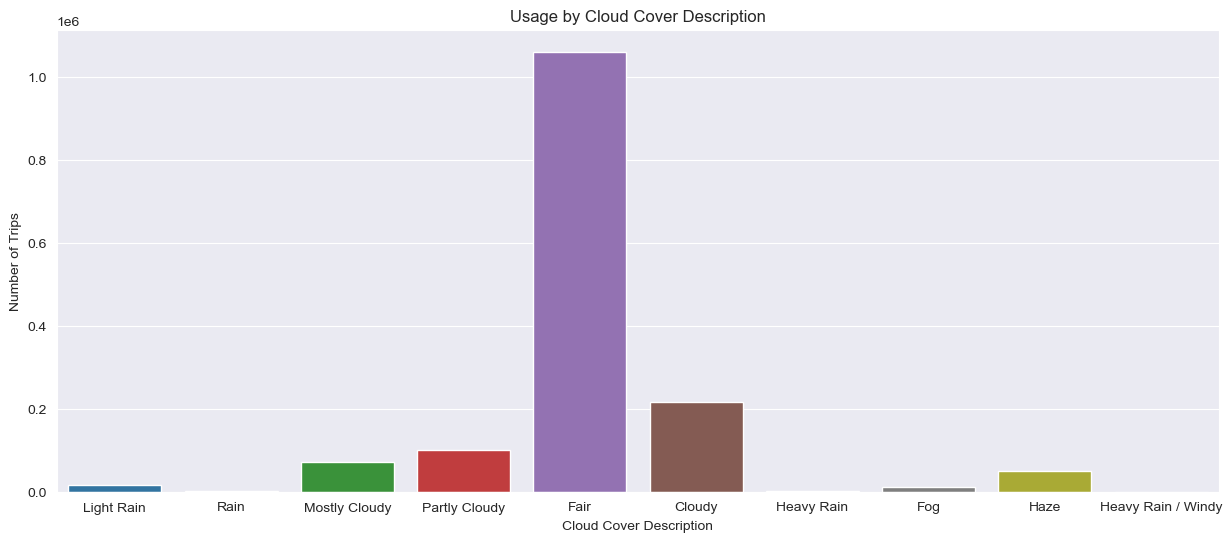

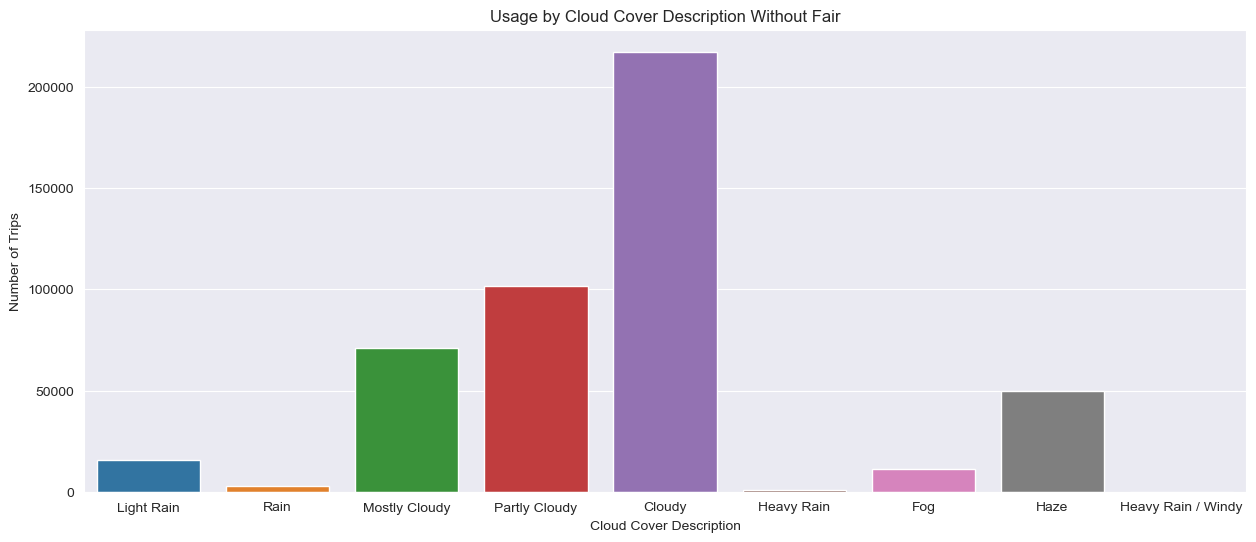

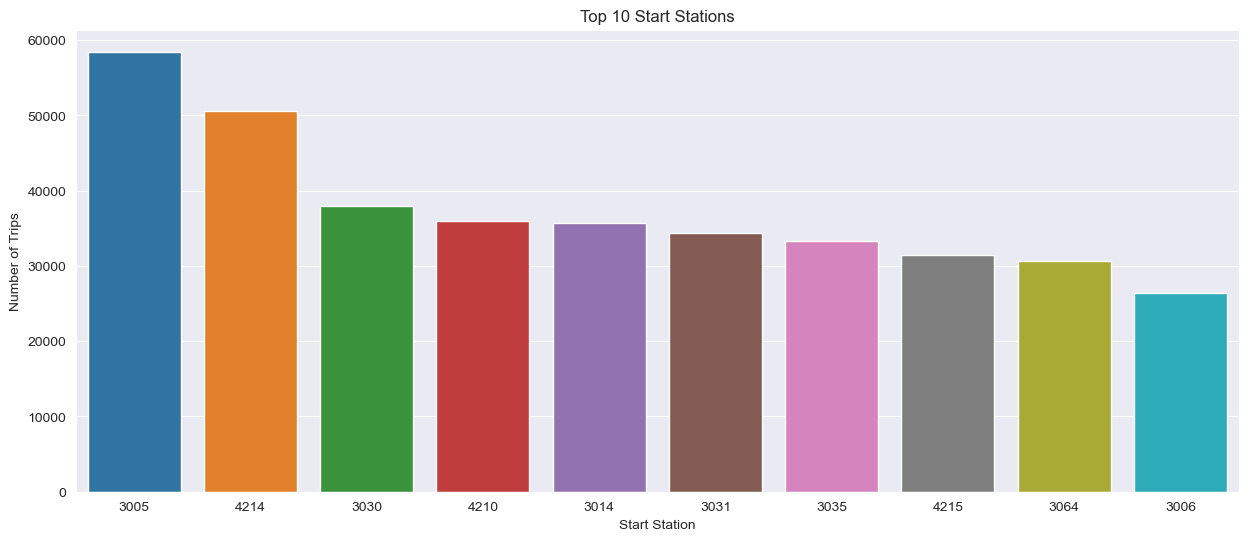

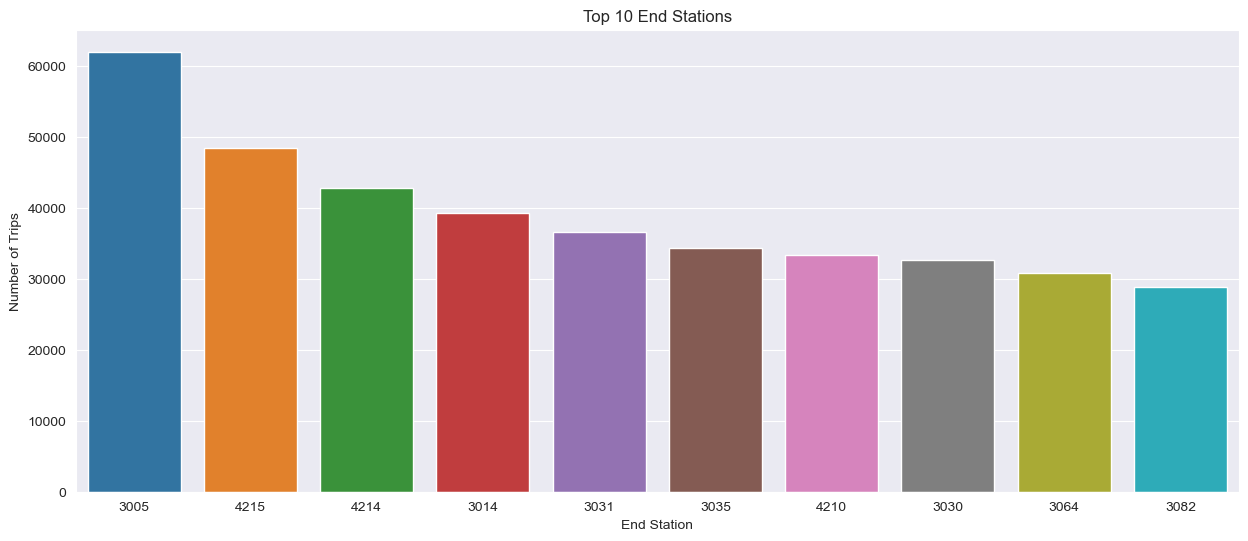

In [9]:
data = merged_set_descriptive.copy()

data['start_time'] = pd.to_datetime(data['start_time'])
data['end_time'] = pd.to_datetime(data['end_time'])
data['trip_duration'] = (data['end_time'] - data['start_time']).dt.total_seconds() / 60

data['hour'] = data['start_time'].dt.hour
data['weekday'] = data['start_time'].dt.day_name()
data['day'] = data['start_time'].dt.day
data['month'] = data['start_time'].dt.month_name()
data['year'] = data['start_time'].dt.year

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data['weekday'] = pd.Categorical(data['weekday'], categories=weekday_order, ordered=True)
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
data['month'] = pd.Categorical(data['month'], categories=month_order, ordered=True)

usage_by_hour = data['hour'].value_counts().sort_index()
usage_by_weekday = data['weekday'].value_counts().sort_index()
usage_by_day = data['day'].value_counts().sort_index()
usage_by_month = data['month'].value_counts().sort_index()
usage_by_year = data['year'].value_counts().sort_index()

usage_by_start_station = data['start_station_id'].value_counts().head(10)
usage_by_end_station = data['end_station_id'].value_counts().head(10)

bins = [0, 10, 20, 30, 40, 50]
labels = ['0-10', '10-20', '20-30', '30-40', '40-50']
data['temperature_bin'] = pd.cut(data['temperature'], bins=bins, labels=labels)
usage_by_temperature = data['temperature_bin'].value_counts()


bins = [-np.inf, 0, 0.5, 2.5, 7.6, np.inf]
labels = ['No', 'Very Light', 'Light', 'Moderate', 'Heavy']
data['precipitation_category'] = pd.cut(data['precipitation'], bins=bins, labels=labels)
usage_by_precipitation = data['precipitation_category'].value_counts()

data_with_precipitation = data[data['precipitation'] > 0].copy()
bins = [0, 0.5, 2.5, 7.6, np.inf]
labels = ['Very Light', 'Light', 'Moderate', 'Heavy']
data_with_precipitation['precipitation_category'] = pd.cut(data_with_precipitation['precipitation'], bins=bins, labels=labels)
usage_by_precipitation2 = data_with_precipitation['precipitation_category'].value_counts()

cloud_cover_categories = ['Light Rain', 'Rain', 'Mostly Cloudy', 'Partly Cloudy', 'Fair', 'Cloudy', 'Heavy Rain', 'Fog', 'Haze', 'Heavy Rain / Windy']
data['cloud_cover_description'] = pd.Categorical(data['cloud_cover_description'], categories=cloud_cover_categories, ordered=True)
usage_by_cloud_cover = data['cloud_cover_description'].value_counts().sort_index()

data_without_fair = data[data['cloud_cover_description'] != 'Fair'].copy()
cloud_cover_categories2 = ['Light Rain', 'Rain', 'Mostly Cloudy', 'Partly Cloudy', 'Cloudy', 'Heavy Rain', 'Fog', 'Haze', 'Heavy Rain / Windy']
data_without_fair['cloud_cover_description'] = pd.Categorical(data_without_fair['cloud_cover_description'], categories=cloud_cover_categories2, ordered=True)
usage_by_cloud_cover2 = data_without_fair['cloud_cover_description'].value_counts().sort_index()

#Visualise Statistics
def bar_plot(usage, title, xlabel, ylabel):
    plt.figure(figsize=(15,6))
    sns.barplot(x=usage.index, y=usage.values)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


bar_plot(usage_by_hour, 'Usage by Hour of the Day', 'Hour of the Day', 'Number of Trips')
bar_plot(usage_by_weekday, 'Usage by Day of the Week', 'Day of the Week', 'Number of Trips')
bar_plot(usage_by_day, 'Usage by Day', 'Day', 'Number of Trips')
bar_plot(usage_by_month, 'Usage by Month', 'Month', 'Number of Trips')
bar_plot(usage_by_year, 'Usage by Year', 'Year', 'Number of Trips')
bar_plot(usage_by_temperature, 'Usage by Temperature', 'Temperature', 'Number of Trips')
bar_plot(usage_by_precipitation, 'Usage by Precipitation', 'Precipitation', 'Number of Trips')
bar_plot(usage_by_precipitation2, 'Usage by Precipitation greater than 0', 'Precipitation', 'Number of Trips')
bar_plot(usage_by_cloud_cover, 'Usage by Cloud Cover Description', 'Cloud Cover Description', 'Number of Trips')
bar_plot(usage_by_cloud_cover2, 'Usage by Cloud Cover Description Without Fair', 'Cloud Cover Description', 'Number of Trips')

plt.figure(figsize=(15, 6))
sns.barplot(x=usage_by_start_station.index.astype(str), y=usage_by_start_station.values)
plt.title('Top 10 Start Stations')
plt.xlabel('Start Station')
plt.ylabel('Number of Trips')
plt.show()

plt.figure(figsize=(15, 6))
sns.barplot(x=usage_by_end_station.index.astype(str), y=usage_by_end_station.values)
plt.title('Top 10 End Stations')
plt.xlabel('End Station')
plt.ylabel('Number of Trips')
plt.show()

#### Station-Level Insights


                                 idle_time  morgens  vormittags  mittags  \
end_station_id                                                             
4403           293 days 23:18:23.586206896       43          90      113   
4321            16 days 08:02:23.571428571       13          15       16   
3039            16 days 06:44:38.608695652       36          59       93   
4363            13 days 15:34:22.466666666       12          13       12   
4432            10 days 23:02:06.598639455       87          94      110   

                nachmittags  abends  nachts  monday  tuesday  wednesday  \
end_station_id                                                            
4403                     43      43      43      42       42         42   
4321                     14      11      12       3        6          6   
3039                     63      34      34      34       34         34   
4363                      8      11      12       6        6          9   
4432             

C:\Users\yusuf\AppData\Local\Temp\ipykernel_120184\737220099.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_data['idle_time'] = pd.to_timedelta(station_data['idle_time']).dt.total_seconds() / (24 * 60 * 60)


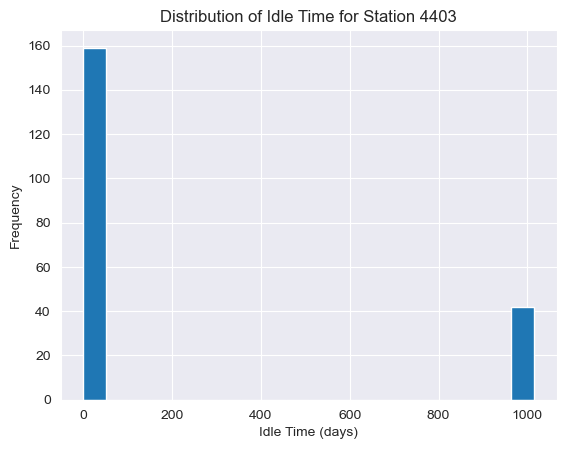

C:\Users\yusuf\AppData\Local\Temp\ipykernel_120184\737220099.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_data['start_time'] = pd.to_datetime(station_data["start_time"])
C:\Users\yusuf\AppData\Local\Temp\ipykernel_120184\737220099.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_data['end_time'] = pd.to_datetime(station_data["end_time"])
C:\Users\yusuf\AppData\Local\Temp\ipykernel_120184\737220099.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

       Trip            End Time     Next Start Time
0   1532899 2020-02-23 13:58:00 2022-12-04 14:54:00
1   1532899 2020-02-23 13:58:00 2022-12-04 14:54:00
2   1532899 2020-02-23 14:00:00 2022-12-04 14:54:00
3   1532899 2020-02-23 14:02:00 2022-12-04 14:54:00
4   1532899 2020-02-23 14:02:00 2022-12-04 14:54:00
5   1532899 2020-02-23 14:05:00 2022-12-04 14:54:00
6   1532899 2020-02-23 14:07:00 2022-12-04 14:54:00
7   1532899 2020-02-23 14:07:00 2022-12-04 14:54:00
8   1532899 2020-02-23 14:09:00 2022-12-04 14:54:00
9   1532899 2020-02-23 14:10:00 2022-12-04 14:54:00
10  1532899 2020-02-23 14:10:00 2022-12-04 14:54:00
11  1532899 2020-02-23 14:10:00 2022-12-04 14:54:00
12  1532899 2020-02-23 14:11:00 2022-12-04 14:54:00
13  1532899 2020-02-23 14:11:00 2022-12-04 14:54:00
14  1532899 2020-02-23 14:14:00 2022-12-04 14:54:00
15  1532899 2020-02-23 14:15:00 2022-12-04 14:54:00
16  1532899 2020-02-23 14:16:00 2022-12-04 14:54:00
17  1532899 2020-02-23 14:18:00 2022-12-04 14:54:00
18  1532899 

ValueError: setting an array element with a sequence.

In [10]:
sorted_df = result.sort_values(by='idle_time', ascending=False)

print(sorted_df.head())

full_data = merged_set_descriptive.copy()
station_data = full_data[(full_data['start_station_id'] == 4403) | (full_data['end_station_id'] == 4403)]
station_data['idle_time'] = pd.to_timedelta(station_data['idle_time']).dt.total_seconds() / (24 * 60 * 60)

plt.hist(station_data['idle_time'], bins=20)
plt.xlabel('Idle Time (days)')
plt.ylabel('Frequency')
plt.title('Distribution of Idle Time for Station 4403')
plt.show()

station_data = full_data[(full_data['start_station_id'] == 4403) | (full_data['end_station_id'] == 4403)]
station_data['start_time'] = pd.to_datetime(station_data["start_time"])
station_data['end_time'] = pd.to_datetime(station_data["end_time"])
station_data['idle_time'] = pd.to_timedelta(station_data['idle_time'])
long_idle_trips = station_data[station_data["idle_time"] > pd.Timedelta(days=1000)]
long_idle_trips = long_idle_trips.sort_values('end_time')
comparison_results = pd.DataFrame(columns=['Trip', 'End Time', 'Next Start Time'])
for index, row in long_idle_trips.iterrows():
    end_time = row['end_time']
    for index, row in station_data.iterrows():
        if row["start_time"] > end_time:
            next_start_time = row["start_time"]
    comparison_results = pd.concat([comparison_results, pd.DataFrame({'Trip': [index], 'End Time': [end_time], 'Next Start Time': [next_start_time]})], ignore_index=True)

print(comparison_results)
print(sorted_df.info())
print(sorted_df.head())
print(type(sorted_df['end_station_lat']))


sorted_df['end_station_lat'] = sorted_df['end_station_lat'].str[1:-1].astype(np.float64)
sorted_df['end_station_lon'] = sorted_df['end_station_lon'].str[1:-1].astype(np.float64)
filtered_df = sorted_df[sorted_df['idle_time'] <= pd.Timedelta(days=30)]
top_20_stations = filtered_df.head(20)
top_20_stations["end_station_id"] = top_20_stations["end_station_id"].astype(str)
plt.figure(figsize=(10, 6))
plt.bar(top_20_stations["end_station_id"], top_20_stations["idle_time"].dt.days)
plt.title("Top 20 Stations with Highest Idle Time")
plt.xlabel("Station ID")
plt.ylabel("Idle Time (Days)")
plt.xticks(rotation=90)
plt.show()

bottom_20_stations = filtered_df.tail(20)
bottom_20_stations["end_station_id"] = bottom_20_stations["end_station_id"].astype(str)
plt.figure(figsize=(10, 6))
plt.bar(bottom_20_stations["end_station_id"], bottom_20_stations["idle_time"].dt.total_seconds()/60)
plt.title("Bottom 20 Stations with Lowest Idle Time")
plt.xlabel("Station ID")
plt.ylabel("Idle Time (Minutes)")
plt.xticks(rotation=90)
plt.show()

print(filtered_df.count())

top_50_percent = filtered_df.head(197)
bottom_50_percent = filtered_df.tail(196)

avg_idle_time_top_50 = top_50_percent["idle_time"].mean()
avg_idle_time_bottom_50 = bottom_50_percent["idle_time"].mean()
over_top_avg_df = top_50_percent[top_50_percent["idle_time"] >= avg_idle_time_top_50]
under_bottom_avg_df = bottom_50_percent[bottom_50_percent["idle_time"] <= avg_idle_time_bottom_50]

over_top_avg_df["neighboring_stations"] = None
over_top_avg_df["avg_neighbor_idle_time"] = None
for i, row in over_top_avg_df.iterrows():
    station_id = row['end_station_id']
    lat = row['end_station_lat']
    lon = row['end_station_lon']
    center_coords = (lat, lon)
    neighbor_idle_time_sum = pd.Timedelta(0)
    neighboring_stations = []
    for index, sorted_row in filtered_df.iterrows():
        station_coords = (sorted_row['end_station_lat'], sorted_row['end_station_lon'])
        dist = distance.distance(center_coords, station_coords).meters
        if dist <= 500:
            neighboring_stations.append(sorted_row["end_station_id"])
            neighbor_idle_time_sum += pd.Timedelta(sorted_row["idle_time"])
    over_top_avg_df.at[i, "neighboring_stations"] = neighboring_stations
    over_top_avg_df.at[i, "avg_neighbor_idle_time"] = neighbor_idle_time_sum / len(neighboring_stations)

under_bottom_avg_df["neighboring_stations"] = None
under_bottom_avg_df["avg_neighbor_idle_time"] = None
for i, row in under_bottom_avg_df.iterrows():
    station_id = row['end_station_id']
    lat = row['end_station_lat']
    lon = row['end_station_lon']
    center_coords = (lat, lon)
    neighbor_idle_time_sum = pd.Timedelta(0)
    neighboring_stations = []
    for index, sorted_row in filtered_df.iterrows():
        station_coords = (sorted_row['end_station_lat'], sorted_row['end_station_lon'])
        dist = distance.distance(center_coords, station_coords).meters
        if dist <= 500:
            neighboring_stations.append(sorted_row["end_station_id"])
            neighbor_idle_time_sum += pd.Timedelta(sorted_row["idle_time"])

under_bottom_avg_df.at[i, "neighboring_stations"] = neighboring_stations
under_bottom_avg_df.at[i, "avg_neighbor_idle_time"] = neighbor_idle_time_sum / len(neighboring_stations)

to_be_removed = []
for i, zeile in over_top_avg_df.iterrows():
    if zeile["idle_time"] > zeile["avg_neighbor_idle_time"] and len(zeile["neighboring_stations"]) > 2:
        to_be_removed.append(zeile["end_station_id"])

to_be_expanded = []
for i, zeile in under_bottom_avg_df.iterrows():
    if zeile["idle_time"] < zeile["avg_neighbor_idle_time"] and len(zeile["neighboring_stations"]) < 3:
        to_be_expanded.append(zeile["end_station_id"])

print(to_be_removed)
print(len(to_be_removed))
print(to_be_expanded)
print(len(to_be_expanded))

la_coordinates = (34.0522, -118.2437)
map_la = folium.Map(location=la_coordinates, zoom_start=11)
for index, row in filtered_df.iterrows():
    station_id = row['end_station_id']
    lat = row['end_station_lat']
    lon = row['end_station_lon']
    if station_id in to_be_expanded:
        folium.Marker(location=[lat, lon], tooltip=[str(station_id)], icon = folium.Icon(color="green")).add_to(map_la)
    elif station_id in to_be_removed:
        folium.Marker(location=[lat, lon], tooltip=[str(station_id)], icon = folium.Icon(color="red")).add_to(map_la)
    else:
        folium.Marker(location=[lat, lon], tooltip=[str(station_id)]).add_to(map_la)
map_la

### 4. Predictive Analytics
#### Preparation
Prepare the data for the machine learning model.
Convert idle time to hours and extract the hour from the end time. Also, encode the cloud cover description using label encoding.

In [11]:
merged_set_pred = merged_set.dropna(subset=["idle_time"]).copy()
merged_set_pred['idle_time'] = merged_set_pred['idle_time'].dt.total_seconds()/3600
merged_set_pred['end_hour'] = merged_set_pred['end_time'].dt.hour

le = LabelEncoder()
merged_set_pred['cloud_cover_description'] = le.fit_transform(merged_set_pred['cloud_cover_description'])

#### Define Target and Feature Variables & Split and Scale Set
Split the data into training, validation, and test sets. Then, standardize the features.

In [12]:
# Define target variable
y = merged_set_pred['idle_time'].values

# Define features
X = merged_set_pred.drop(['start_time', 'end_time', 'bike_id', 'idle_time', 'start_station_id','start_station_lat','start_station_lon'], axis=1)

# Extract feature names
feature_names = X.columns.tolist()

# Perform train-validation-test split
X_train_val, X_test, y_train_val, y_test = train_test_split(X[feature_names], y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.285, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_train_val = scaler.transform(X_train_val)
X_test = scaler.transform(X_test)



#### Train and Evaluate Models
Perform hyperparameter tuning for the LightGBM using grid search. Print the best hyperparameters and the corresponding R-squared score.

In [13]:
# Define the parameter lgbm_grid
param_grid = {
    'max_depth': [10, 20, 30],
    'learning_rate': [0.01, 0.1, 1],
    'num_leaves': [31, 62, 93],
    'n_estimators': [100, 200, 300]
}

# Create a LightGBM model
lgbm_model = lgb.LGBMRegressor()

# Create the lgbm_grid search object
lgbm_grid = GridSearchCV(lgbm_model, param_grid, cv=5, scoring='r2')

# Fit the lgbm_grid search object to the data
lgbm_grid.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print(lgbm_grid.best_params_)
print(lgbm_grid.best_score_)

{'learning_rate': 0.1, 'max_depth': 30, 'n_estimators': 300, 'num_leaves': 62}
0.9247843930059483


Perform hyperparameter tuning for the Decision Tree model using grid search. Print the best hyperparameters and the corresponding R-squared score.

In [14]:
# Define the parameter tree_grid
param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [1.0, 'sqrt', 'log2', None]
}

# Create a DecisionTreeRegressor model
decTree_model = DecisionTreeRegressor()

# Create the tree_grid search object
tree_grid = GridSearchCV(decTree_model, param_grid, cv=5, scoring='r2')

# Fit the tree_grid search object to the data
tree_grid.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print(tree_grid.best_params_)
print(tree_grid.best_score_)

{'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2}
0.8987161577698893


Make predictions on the validation set using the best Decision Tree and LightGBM models. Compute the MSE, MAE, and R-squared score for each model. Plot these metrics for comparison.

Decision Tree: 2712.6673974753016
LightGBM: 2231.5359891300923


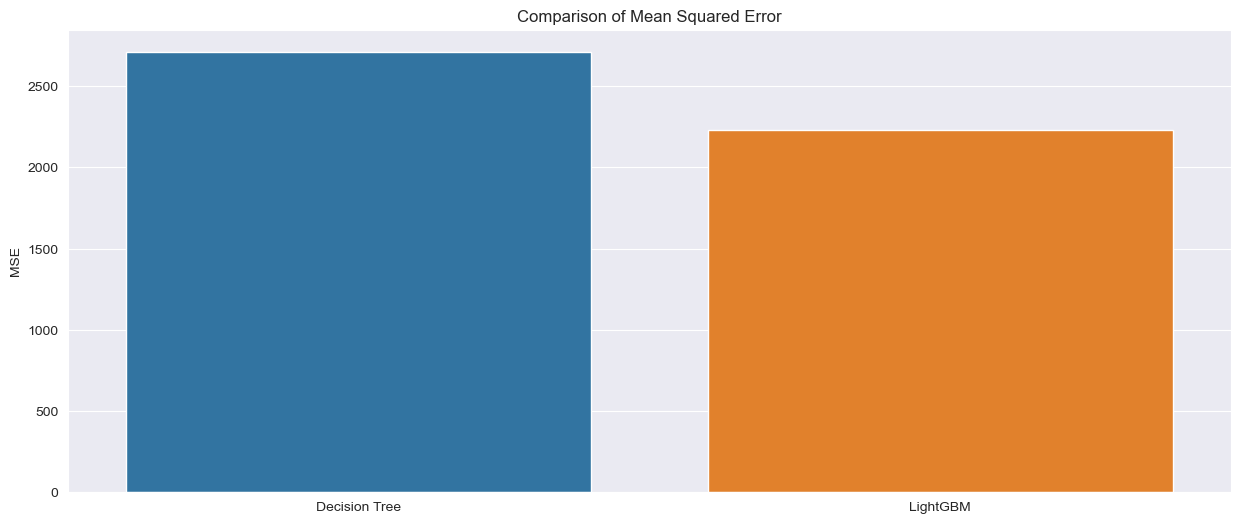

Decision Tree: 2.9697077406655388
LightGBM: 4.022247497762067


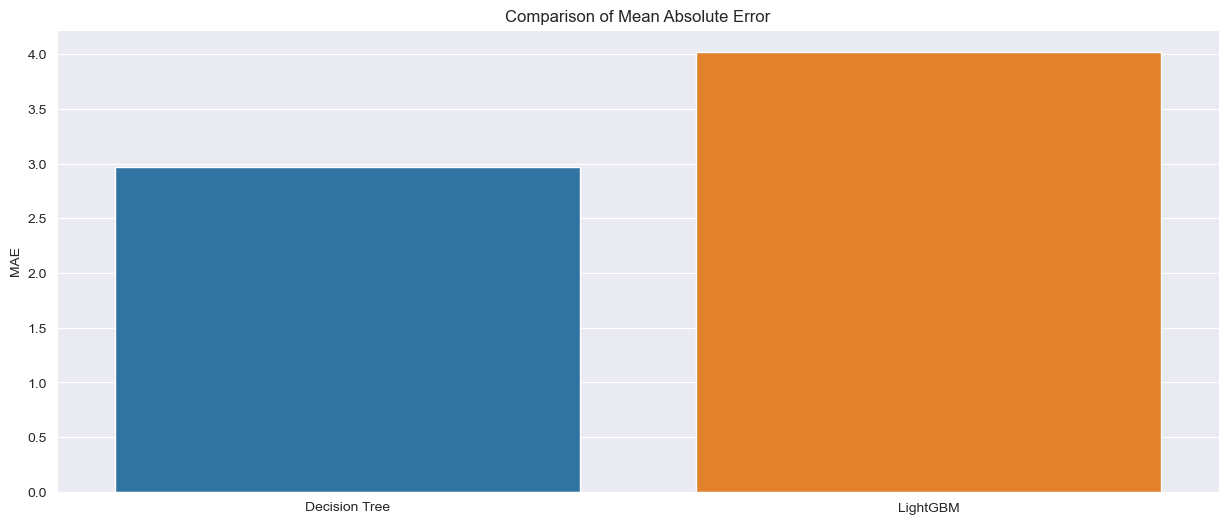

Decision Tree: 0.9001443632878868
LightGBM: 0.9178552272025787


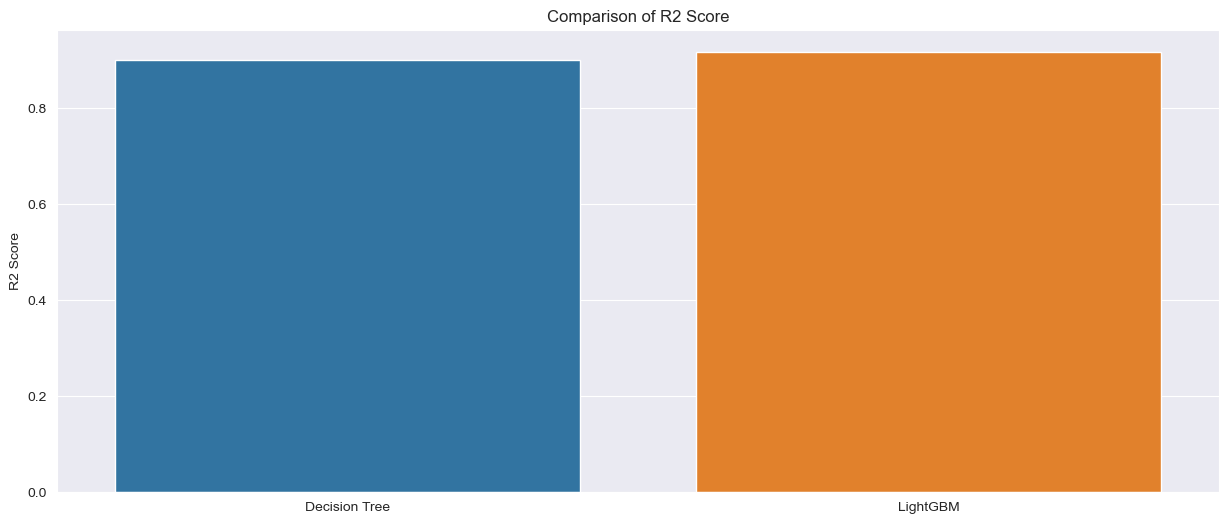

In [15]:
y_pred_tree = tree_grid.best_estimator_.predict(X_val)
y_pred_lgbm = lgbm_grid.best_estimator_.predict(X_val)

mse_tree = mean_squared_error(y_val, y_pred_tree)
mae_tree = mean_absolute_error(y_val, y_pred_tree)
r2_tree = r2_score(y_val, y_pred_tree)
mse_lgbm = mean_squared_error(y_val, y_pred_lgbm)
mae_lgbm = mean_absolute_error(y_val, y_pred_lgbm)
r2_lgbm = r2_score(y_val, y_pred_lgbm)

models = ['Decision Tree', 'LightGBM']
mse_values = [mse_tree, mse_lgbm]
mae_values = [mae_tree, mae_lgbm]
r2_values = [r2_tree, r2_lgbm]

def comparison_plot(values, title, models, ylabel):
    plt.figure(figsize=(15, 6))
    sns.barplot(x=models, y=values)
    plt.title(title)
    plt.ylabel(ylabel)
    for model, value in zip(models, values):
        print(f"{model}: {value}")
    plt.show()


comparison_plot(mse_values, 'Comparison of Mean Squared Error', models, 'MSE')
comparison_plot(mae_values, 'Comparison of Mean Absolute Error',models, 'MAE')
comparison_plot(r2_values, 'Comparison of R2 Score',models, 'R2 Score')

Create a Stacking Regressor model with the best Decision Tree and LightGBM models as base models, and Lasso as the meta model. Train this model on the training data.

In [16]:
best_params_tree = tree_grid.best_params_
best_params_lgbm = lgbm_grid.best_params_

base_models = [
    ('decision_tree', DecisionTreeRegressor(**best_params_tree)),
    ('lgbm', LGBMRegressor(**best_params_lgbm))
]

# Define the meta model
meta_model = Lasso()

final_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)
final_model.fit(X_train, y_train)

StackingRegressor(estimators=[('decision_tree',
                               DecisionTreeRegressor(max_depth=30,
                                                     max_features='log2',
                                                     min_samples_leaf=2)),
                              ('lgbm',
                               LGBMRegressor(max_depth=30, n_estimators=300,
                                             num_leaves=62))],
                  final_estimator=Lasso())

Make predictions on the validation set using the Stacking Regressor model. Compute the MSE, MAE, and R-squared score. Add these metrics to the previous ones and plot them for comparison.

Decision Tree: 2712.6673974753016
LightGBM: 2231.5359891300923
StackingRegressor: 2142.9931488074567


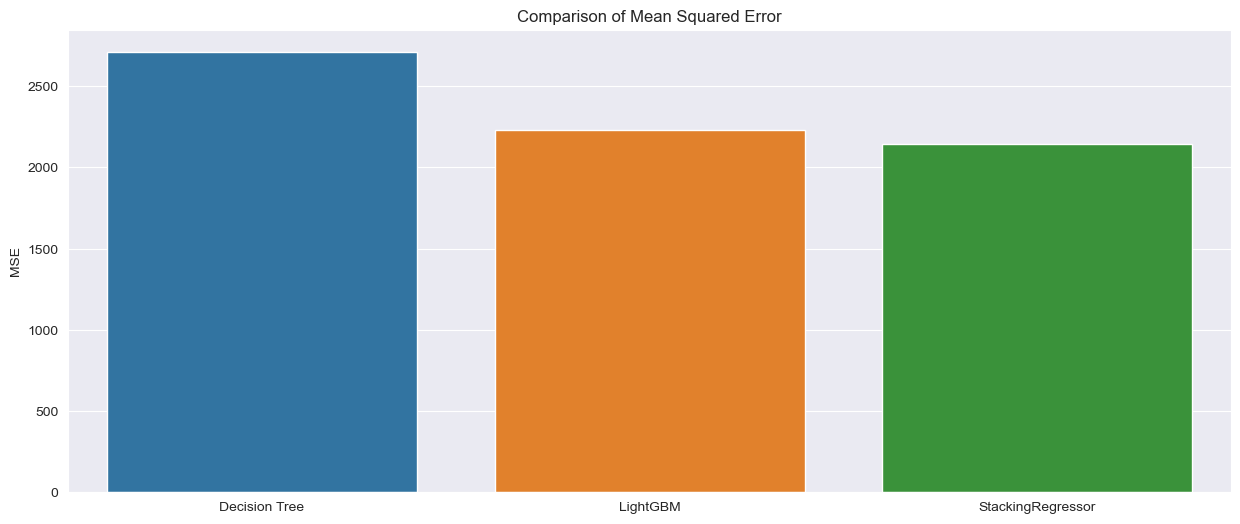

Decision Tree: 2.9697077406655388
LightGBM: 4.022247497762067
StackingRegressor: 3.8507886436785


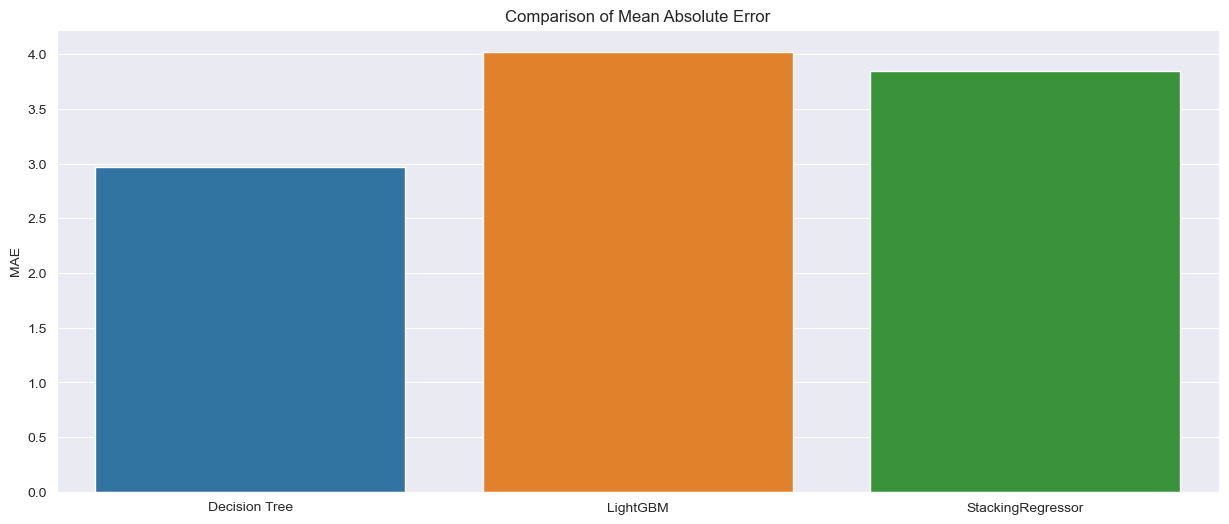

Decision Tree: 0.9001443632878868
LightGBM: 0.9178552272025787
StackingRegressor: 0.9211145658538799


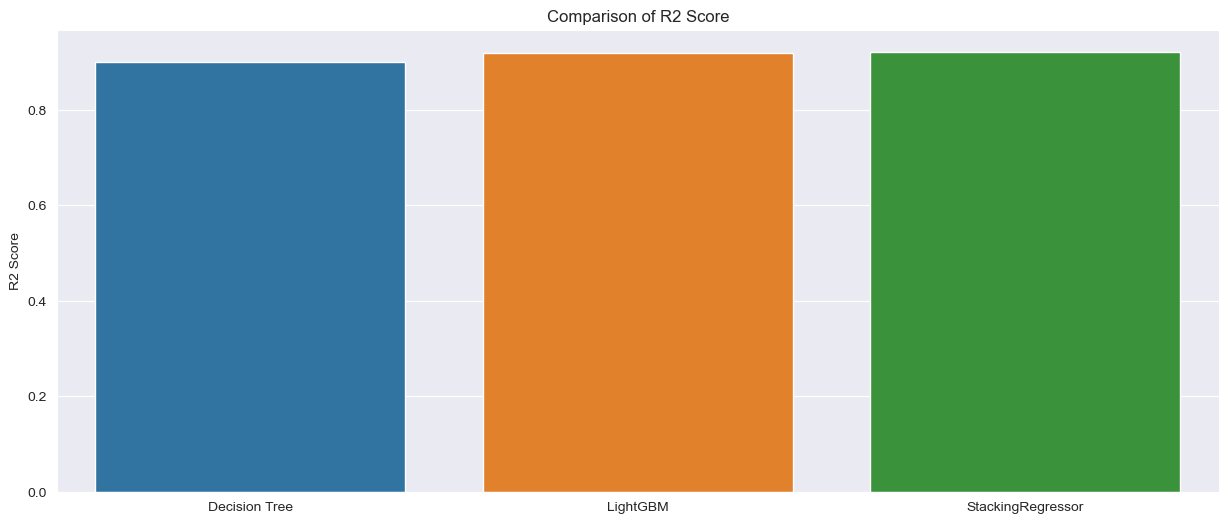

In [17]:
y_pred_final = final_model.predict(X_val)
mse_final = mean_squared_error(y_val, y_pred_final)
mae_final = mean_absolute_error(y_val, y_pred_final)
r2_final = r2_score(y_val, y_pred_final)

models.append('StackingRegressor')
mse_values.append(mse_final)
mae_values.append(mae_final)
r2_values.append(r2_final)

comparison_plot(mse_values, 'Comparison of Mean Squared Error', models, 'MSE')
comparison_plot(mae_values, 'Comparison of Mean Absolute Error', models,'MAE')
comparison_plot(r2_values, 'Comparison of R2 Score', models,'R2 Score')

Based on these results, both models show potential and perform well on the dataset.
However, the LightGBM model seems to perform slightly better overall, due to its lower MSE and higher R2 score.

Make predictions on the Test set using the Stacking Regressor model. Compute the MSE, MAE, and R-squared score. Add these metrics to the previous ones and plot them for comparison.

Decision Tree (Validation Set): 2712.6673974753016
LightGBM (Validation Set): 2231.5359891300923
StackingRegressor (Validation Set): 2142.9931488074567
StackingRegressor (Test Set): 2067.943016961981


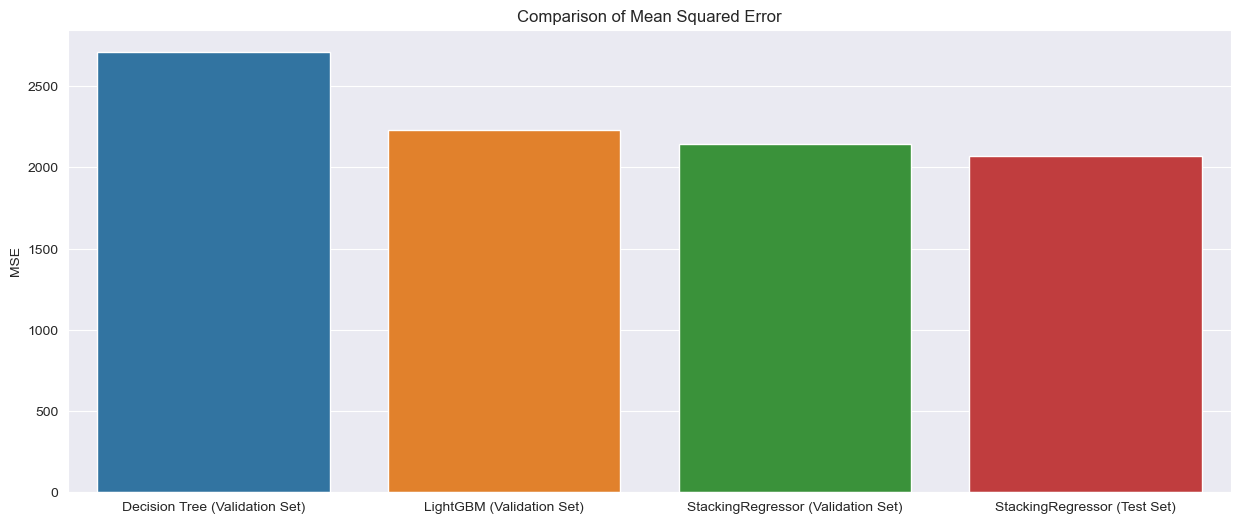

Decision Tree (Validation Set): 2.9697077406655388
LightGBM (Validation Set): 4.022247497762067
StackingRegressor (Validation Set): 3.8507886436785
StackingRegressor (Test Set): 3.9405395655317403


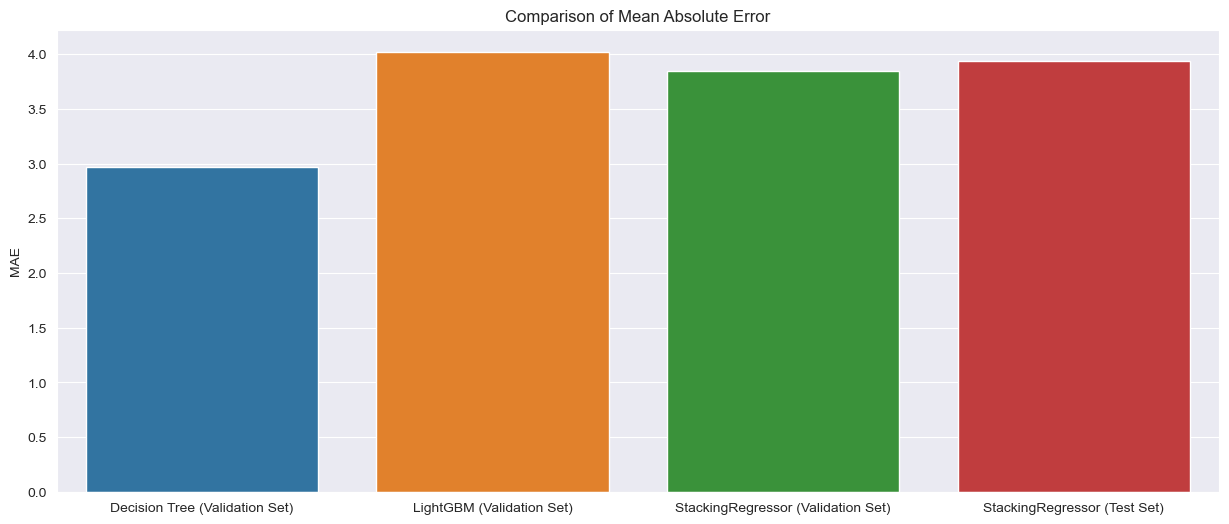

Decision Tree (Validation Set): 0.9001443632878868
LightGBM (Validation Set): 0.9178552272025787
StackingRegressor (Validation Set): 0.9211145658538799
StackingRegressor (Test Set): 0.9202038615372097


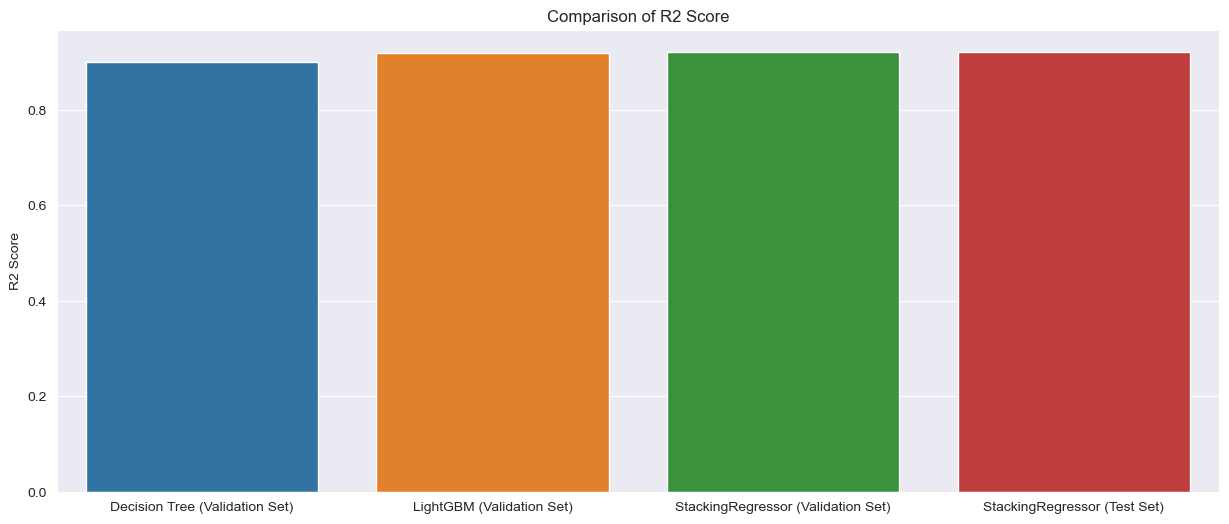

In [18]:
y_pred_test = final_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

final_models = ['Decision Tree (Validation Set)', 'LightGBM (Validation Set)', 'StackingRegressor (Validation Set)', 'StackingRegressor (Test Set)']
mse_values.append(test_mse)
mae_values.append(test_mae)
r2_values.append(test_r2)

comparison_plot(mse_values, 'Comparison of Mean Squared Error', final_models, 'MSE')
comparison_plot(mae_values, 'Comparison of Mean Absolute Error', final_models, 'MAE')
comparison_plot(r2_values, 'Comparison of R2 Score', final_models, 'R2 Score')

Based on this evaluation, the Stacking Regressor demonstrates robust performance and good generalization, making it a strong candidate for deployment.